In [15]:
%matplotlib notebook

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from icecream import ic
from STOM_higgs_tools import generate_data, get_B_chi, get_B_expectation
from scipy.stats import chi2
from tqdm.notebook import tqdm
np.random.seed(1)

In [17]:
def exponential_distribution(x: np.ndarray, A: float, lamb: float) -> np.ndarray:
    #Exponential distribution function for background events.

    return A* np.exp(-x/lamb)


def gaussian_distribution(x: np.ndarray, B: float, mu: float, sigma: float) -> np.ndarray:
    #Gaussian distribution function for signal events. 
    return B/np.sqrt(2*np.pi*sigma**2) * np.exp(-(x-mu)**2 / (2*sigma**2))


def combined_distribution(x: np.ndarray, *params) -> np.ndarray:
    #Combined distribution of exponential background and Gaussian signal.
    A, lamb, B, mu, sigma = params
    return exponential_distribution(x, A, lamb) + gaussian_distribution(x, B, mu, sigma)


 # Task 1

<IPython.core.display.Javascript object>

/var/folders/rv/n60z7tpj7z7d9f_gyq2v677w0000gn/T/ipykernel_46482/2540747549.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


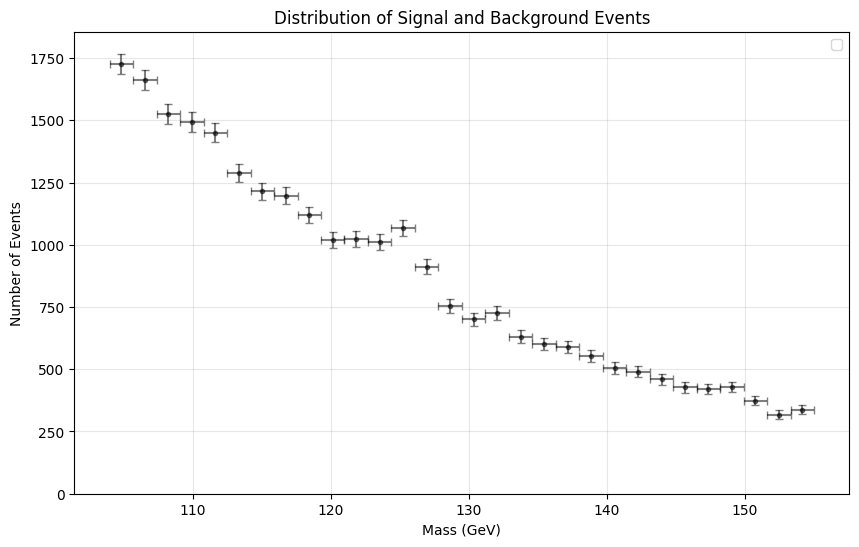

In [18]:

# Generate and prepare data
# Generate and prepare data
amplitude_values = np.array(generate_data())

# Define histogram parameters
MASS_RANGE = (104, 155)
NUM_BINS = 30
SIGNAL_REGION = (120, 130)

# Create histogram
fig, ax = plt.subplots(figsize=(10, 6))

# plt.hist returns bin_heights, bin_edges, patches
# where bin_heights is the number of events in each bin
# bin_edges is the coordinates of the bin edges
bin_heights, bin_edges, _ = ax.hist(
    amplitude_values, 
    bins=NUM_BINS, 
    alpha=0, 
    color='blue', 
    edgecolor='black', 
    range=MASS_RANGE
)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
uncertainties = np.sqrt(bin_heights)  # Poisson uncertainty

bin_width = bin_edges[1] - bin_edges[0]
x_uncertainties = bin_width / 2
# Plot error bars
ax.errorbar(
    bin_centers, 
    bin_heights, 
    yerr=uncertainties, 
    xerr=x_uncertainties, 
    fmt='k.', 
    capsize=3, 
    alpha=0.5
)
# Customize plot
ax.set_xlabel('Mass (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title('Distribution of Signal and Background Events')
ax.grid(True, alpha=0.3)
ax.legend()
display(fig)

# Task 2

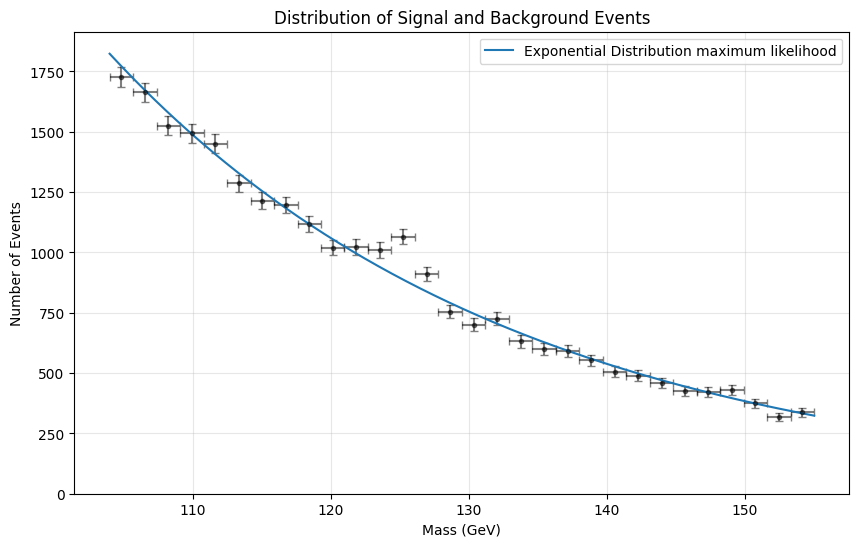

In [19]:

background_values = np.concatenate((
    amplitude_values[amplitude_values < SIGNAL_REGION[0]],
    amplitude_values[amplitude_values > SIGNAL_REGION[1]]
))
bin_heights_signal = bin_heights[
    (bin_centers >= SIGNAL_REGION[0]) & 
    (bin_centers <= SIGNAL_REGION[1])
]
bin_centers_signal = bin_centers[
    (bin_centers >= SIGNAL_REGION[0]) & 
    (bin_centers <= SIGNAL_REGION[1])
]

area_under_histogram = np.sum(bin_heights) * bin_width
lamb_estimate_max_likelihood = np.sum(background_values) / len(background_values)
A_estimate_max_likelihood = area_under_histogram / (
    lamb_estimate_max_likelihood * 
    (np.exp(-MASS_RANGE[0]/lamb_estimate_max_likelihood) - 
        np.exp(-MASS_RANGE[1]/lamb_estimate_max_likelihood))
)

# Plot results
x_fine = np.linspace(*MASS_RANGE, 1000)

# Plot background distribution
ax.plot(
    x_fine,
    exponential_distribution(x_fine, A_estimate_max_likelihood, lamb_estimate_max_likelihood),
    label='Exponential Distribution maximum likelihood'
)
ax.legend()
display(fig)

# TASK 3

In [20]:

# function to calculate chi-square for a given bin
def chi_square(bin_edges, amplitude_values, A, lamb):
    # left_bin_edges = bin_edges[bin_edges < 121]
    left_bin_edges = bin_edges[bin_edges < SIGNAL_REGION[0]]
    right_bin_edges = bin_edges[bin_edges > SIGNAL_REGION[1]]
    # -1 because the bin edges are not included in the bin_heights
    N_para_left = len(left_bin_edges)-1
    N_para_right = len(right_bin_edges)-1
    chi_left = get_B_chi(amplitude_values, (MASS_RANGE[0], left_bin_edges[0]), left_bin_edges, A, lamb)
    chi_right = get_B_chi(amplitude_values, (right_bin_edges[-1], MASS_RANGE[1]), right_bin_edges, A, lamb)
    total_chi = chi_left + chi_right
    total_dof = N_para_left + N_para_right-4
    # reduce chi-square to a single value
    return total_chi/total_dof

def iterate_chi(A, lamb, n=10):
    lambda_range = np.linspace(lamb*0.99, lamb*1.01, n)
    A_range = np.linspace(A*0.99, A*1.01, n) 
    # Create meshgrid for 3D plotting
    LAMBDA, A = np.meshgrid(A_range, lambda_range)
    chi_square_values = np.zeros_like(LAMBDA) 
    # Calculate chi-square values for each combination
    for i, A_val in enumerate(tqdm(A_range)):
        for j, lambda_val in enumerate(lambda_range):
            chi_square_values[i, j] = chi_square(bin_edges, amplitude_values, 
                                            A_val, lambda_val) 
    # Find the chi-square value closest to 1
    min_diff_to_one = np.argmin(np.abs(chi_square_values - 1))
    # Get the corresponding A and lambda values
    A_idx = min_diff_to_one//len(A_range)
    lambda_idx = min_diff_to_one%len(lambda_range)
    A_min = A_range[A_idx]
    lamb_min = lambda_range[lambda_idx]
    chi_min = chi_square_values[A_idx, lambda_idx]

    #save LAMBDA, A, chi_square_values to a npy file
    np.save('chi_square_values.npy', (LAMBDA, A, chi_square_values))

    # save min values to a file
    np.savetxt('min_values.txt', (A_min, lamb_min, chi_min))
    return A_min, lamb_min, chi_min

def load_chi_square_values():
    LAMBDA, A, chi_square_values = np.load('chi_square_values.npy')
    return LAMBDA, A, chi_square_values
def load_min_values():
    A_min, lamb_min, chi_min = np.loadtxt('min_values.txt')
    return A_min, lamb_min, chi_min
def plot_chi_square_surface(LAMBDA, A, chi_square_values):
    fig_chi = plt.figure(figsize=(10, 8))
    ax_chi = fig_chi.add_subplot(111, projection='3d')
    ax_chi.plot_surface(LAMBDA, A, chi_square_values, cmap='viridis')
    ax_chi.set_xlabel('Lambda')
    ax_chi.set_ylabel('A')
    ax_chi.set_zlabel('Chi-square')
    ax_chi.set_title('Chi-square for different Lambda and A values') 
    display(fig_chi)

def find_amplitude_for_p_value(A_guess, lamb_guess, mu_guess, sigma_guess, target_p_value=0.05): 
    # Binary search to find B
    B_min = 0
    B_max = 1000  # Start with a reasonable upper bound
    tolerance = 0.001
    max_iterations = 50
    
    for _ in range(max_iterations):
        B_test = (B_min + B_max) / 2
        test_params = [A_guess, lamb_guess, B_test, mu_guess, sigma_guess]
        
        # Calculate chi-square and p-value
        chi_combined = get_SB_chi(bin_centers, bin_heights, test_params)
        dof = len(bin_edges) - 5 - 1
        current_p_value = 1 - chi2.cdf(chi_combined, dof)
        
        if abs(current_p_value - target_p_value) < tolerance:
            return B_test
        
        if current_p_value > target_p_value:
            B_max = B_test
        else:
            B_min = B_test
    
    return (B_min + B_max) / 2  # Return the best approximation
    

# ONLY RUN THE CODE BELOW IF YOU NEED TO RELOAD THE RESULT

In [8]:
iterate_chi(A_estimate_max_likelihood, lamb_estimate_max_likelihood,20)

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

ic| chi_square_calc_max_likelihood: np.float64(1.0015997103124779)


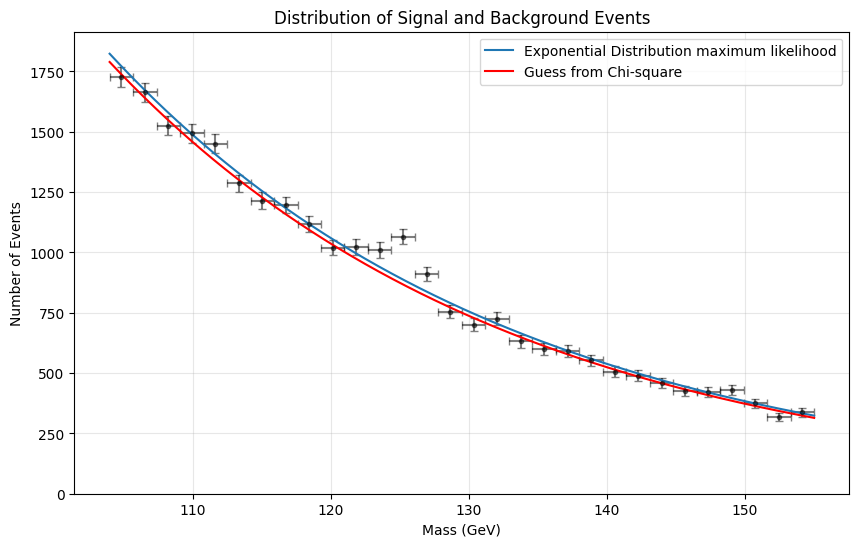

<IPython.core.display.Javascript object>

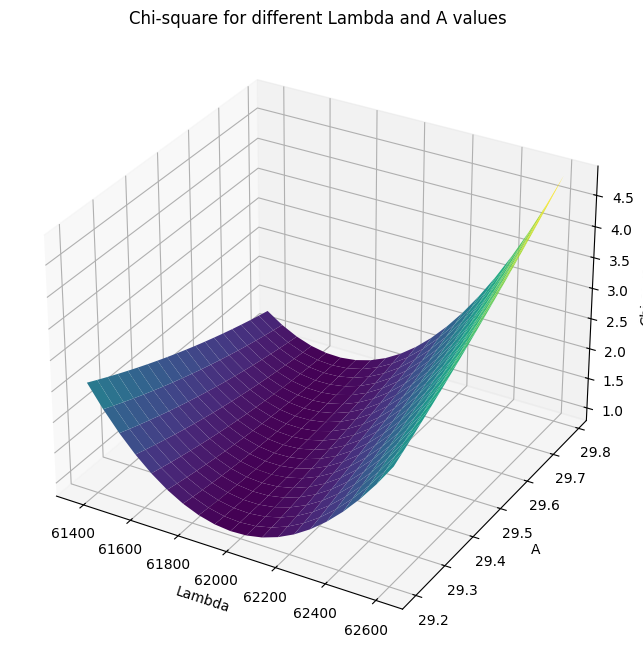

In [21]:

LAMBDA, A, chi_square_values = load_chi_square_values()
A_chi, lamb_chi, chi_min = load_min_values()
chi_square_calc_max_likelihood = chi_square(bin_edges, amplitude_values, A_estimate_max_likelihood, lamb_estimate_max_likelihood)
ic(chi_square_calc_max_likelihood)
# plot these value on the graph
ax.plot(x_fine, exponential_distribution(x_fine, A_chi, lamb_chi), 'r', label='Guess from Chi-square')
ax.legend()
display(fig)
plot_chi_square_surface(LAMBDA, A, chi_square_values)

# TASK 4

A: do a chi square test for the background and signal

In [22]:

chi_background_and_signal = get_B_chi(amplitude_values, MASS_RANGE, NUM_BINS, A_chi, lamb_chi)
ic(chi_background_and_signal)

# Calculate p-value and confidence thresholds
data_points = len(bin_edges) - 1  # degrees of freedom (number of bins - number of parameters)
# because of two degree of freedom, we need to subtract 2, (A and lambda)
dof = data_points - 2
p_value = 1 - chi2.cdf(chi_background_and_signal, dof)

# Calculate chi-square values for different confidence levels
chi2_90 = chi2.ppf(0.90, dof)
chi2_95 = chi2.ppf(0.95, dof)
chi2_99 = chi2.ppf(0.99, dof)

ic(p_value)
ic(chi2_90, chi2_95, chi2_99)

ic| chi_background_and_signal: np.float64(88.52659995721211)
ic| p_value: np.float64(3.362796185957251e-08)
ic| chi2_90: np.float64(37.915922544697075)
    chi2_95: np.float64(41.3371381514274)
    chi2_99: np.float64(48.27823577031551)


(np.float64(37.915922544697075),
 np.float64(41.3371381514274),
 np.float64(48.27823577031551))

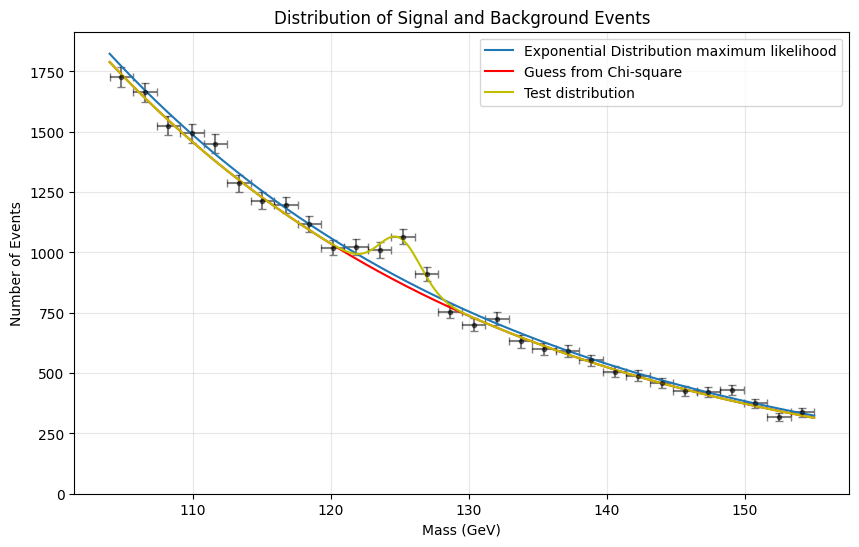

ic| chi_combined: np.float64(23.043881178641964)
ic| dof: 25
ic| chi_combined/dof: np.float64(0.9217552471456786)
ic| "Chi-square for combined distribution:": 'Chi-square for combined distribution:'
    chi_combined: np.float64(23.043881178641964)
ic| 'p-value:', p_value: np.float64(0.5750008913204445)
ic| "Chi-square thresholds (99%,  99.999%, 99.99999%):": 'Chi-square thresholds (99%,  99.999%, 99.99999%):'
    chi2_99: np.float64(44.314104896219135)
    chi2_99999: np.float64(67.18175122781993)
    chi2_9999999: np.float64(80.36536325743589)
ic| 'Acceptance at 99%:', chi_combined < chi2_99: np.True_
ic| 'Acceptance at 99.999%:', chi_combined < chi2_99999: np.True_
ic| 'Acceptance at 99.99999%:', chi_combined < chi2_9999999: np.True_


('Acceptance at 99.99999%:', np.True_)

In [23]:

B_TEST = 700
MU_TEST = 125
SIGMA_TEST = 1.5
test_params = [A_chi, lamb_chi, B_TEST, MU_TEST, SIGMA_TEST]
    
def get_SB_chi(bin_centers, bin_heights, fitted_params):
    ys_expected = combined_distribution(bin_centers, *fitted_params)
    # Loop over bins - all of them for now. 
    chi = np.sum((bin_heights - ys_expected)**2 / ys_expected)
    return chi 

ax.plot(x_fine, combined_distribution(x_fine, *test_params), 'y', label='Test distribution')
ax.legend()
display(fig)

# Calculate chi-square with test parameters
chi_combined = get_SB_chi(bin_centers, bin_heights, test_params) 
dof = len(bin_edges) - 5 - 1
ic(chi_combined)
ic(dof)
ic(chi_combined/dof)
# Calculate p-value and confidence thresholds
data_points = len(bin_edges) - 1
dof = data_points - 5  # 5 parameters: A, lambda, B, mu, sigma
p_value = 1 - chi2.cdf(chi_combined, dof)

# Calculate chi-square values for different confidence levels
chi2_99 = chi2.ppf(0.99, dof)
chi2_99999 = chi2.ppf(0.99999, dof)
chi2_9999999 = chi2.ppf(0.9999999, dof)

ic("Chi-square for combined distribution:", chi_combined)
ic("p-value:", p_value)
ic("Chi-square thresholds (99%,  99.999%, 99.99999%):", chi2_99, chi2_99999, chi2_9999999)
ic("Acceptance at 99%:", chi_combined < chi2_99)
ic("Acceptance at 99.999%:", chi_combined < chi2_99999)
ic("Acceptance at 99.99999%:", chi_combined < chi2_9999999)


C: find the amplitude corresponding to a p-value of 0.05

In [24]:
# Find the amplitude that corresponds to a p-value of 0.05
amplitude_for_p_value = find_amplitude_for_p_value(A_chi, lamb_chi, MU_TEST, SIGMA_TEST, 0.05)
ic("Signal amplitude B for p-value 0.05:", amplitude_for_p_value)

# Verify the result
test_params = [A_chi, lamb_chi, amplitude_for_p_value, 125, 1.5]
chi_combined = get_SB_chi(bin_centers, bin_heights, test_params)
dof = len(bin_edges) - 5 - 1
p_value = 1 - chi2.cdf(chi_combined, dof)
ic("Verification - p-value:", p_value)

ic| "Signal amplitude B for p-value 0.05:": 'Signal amplitude B for p-value 0.05:'
    amplitude_for_p_value: 363.28125
ic| "Verification - p-value:": 'Verification - p-value:'
    p_value: np.float64(0.04990443457788463)


('Verification - p-value:', np.float64(0.04990443457788463))

D: Plot chi_square for different mu values

<IPython.core.display.Javascript object>

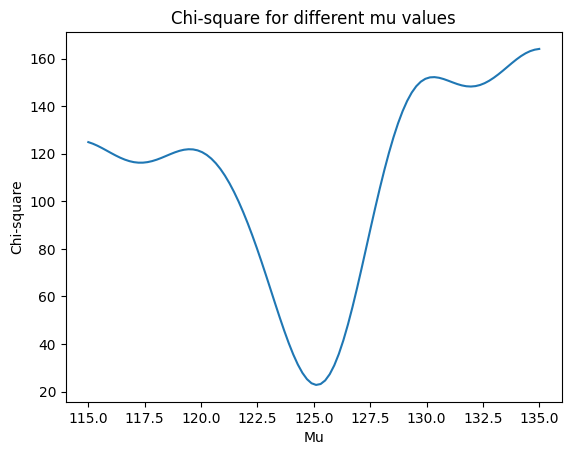

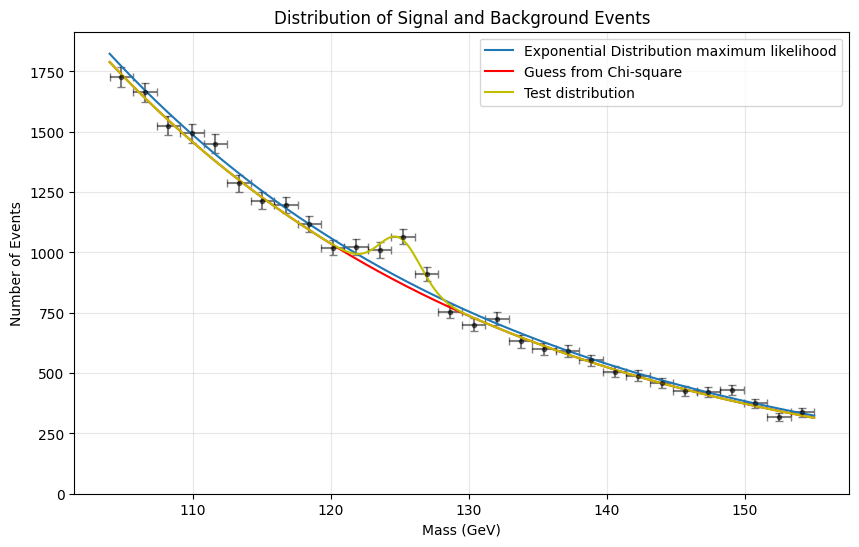

In [25]:

# new plot
fig_mu, ax_mu = plt.subplots()
def find_chi_for_mu(mu_values):
    chi_values = []
    for mu in mu_values:
        test_params = [A_chi, lamb_chi, B_TEST, mu, SIGMA_TEST]
        chi_combined = get_SB_chi(bin_centers, bin_heights, test_params)
        chi_values.append(chi_combined)
    return chi_values

mu_values = np.linspace(MU_TEST-10, MU_TEST+10, 100)
chi_values = find_chi_for_mu(mu_values)
ax_mu.plot(mu_values, chi_values)
ax_mu.set_xlabel('Mu')
ax_mu.set_ylabel('Chi-square')
ax_mu.set_title('Chi-square for different mu values')
display(fig_mu)
display(fig)
        
